## Imports

In [1]:
import copy
import gurobipy as gp
import json
import math
import numpy as np
import os
import pandas as pd
import random
from gurobipy import GRB
from pprint import pprint

## Read Data

In [2]:
TRANSFER_PERCENTAGE = 0
# TRANSFER_PERCENTAGE = 0.25

if TRANSFER_PERCENTAGE > 0:
    INPUT_PATH = f"data/boston-logan/transfers/{TRANSFER_PERCENTAGE}"
else:
    INPUT_PATH = "data/boston-logan"

arrivals_df = pd.read_csv(os.path.join(INPUT_PATH, "arrivals.csv"))
departures_df = pd.read_csv(os.path.join(INPUT_PATH, "departures.csv"))
gates_df = pd.read_excel("data/boston-logan/Gates.xlsx")

if TRANSFER_PERCENTAGE > 0:
    with open(os.path.join(INPUT_PATH, "transfers.json")) as json_file:
        transfers = json.load(json_file)

all_flights_df = pd.concat([arrivals_df, departures_df])

In [3]:
arrivals_df

,Unnamed: 0,Flight Number,Arrival Time,Departure Time,Passengers,Type
0,0,2,25,136,106,Arrival
1,1,3,41,161,147,Arrival
2,2,6,73,187,187,Arrival
3,3,7,77,188,121,Arrival
4,4,10,111,233,94,Arrival
...,...,...,...,...,...,...
63,63,120,1325,1447,127,Arrival
64,64,124,1369,1499,88,Arrival
65,65,126,1390,1513,240,Arrival
66,66,127,1398,1513,87,Arrival


In [4]:
gates_df ## Gates Start from 1 (Gate 0 is the terminal entry)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,53,45,43,31,29,25,23,19,9,3,15,17,21,23
1,1,53,0,4,10,22,24,28,30,34,44,50,62,64,68,70
2,2,45,4,0,6,18,20,24,26,30,40,46,58,60,64,66
3,3,43,10,6,0,12,14,18,20,24,34,40,52,54,58,60
4,4,31,22,18,12,0,2,6,8,12,22,28,40,42,46,48
5,5,29,24,20,14,2,0,4,6,10,20,26,38,40,44,46
6,6,25,28,24,18,6,4,0,2,6,16,22,34,36,40,42
7,7,23,30,26,20,8,6,2,0,4,14,20,32,34,38,40
8,8,19,34,30,24,12,10,6,4,0,10,16,28,30,34,36
9,9,9,44,40,34,22,20,16,14,10,0,6,18,20,24,26


## Utility Functions

In [5]:
def get_distance(i, j):
    return gates_df[i][j]

def get_arrival_time(i):
    result = all_flights_df[all_flights_df["Flight Number"] == i]["Arrival Time"]
    assert(len(result) == 1)
    return int(result)

def get_departure_time(i):
    result = all_flights_df[all_flights_df["Flight Number"] == i]["Departure Time"]
    assert(len(result) == 1)
    return int(result)

def get_num_passengers(i):
    result = all_flights_df[all_flights_df["Flight Number"] == i]["Passengers"]
    assert(len(result) == 1)
    return int(result)

### Tests

In [6]:
assert(get_distance(5,3) == 14)
assert(get_distance(14,14) == 0)
assert(get_distance(4,11) == 40)

In [7]:
## Basic Assertions on the Data
flight_numbers = sorted(list(arrivals_df["Flight Number"]) + list(departures_df["Flight Number"]))
assert(flight_numbers == list(range(1,131)))

flight_numbers = sorted(list(all_flights_df["Flight Number"]))
assert(flight_numbers == list(range(1,131)))

## Parameters

In [8]:
num_flights = 130
num_gates = 14

## Descriptors (for variables)

In [9]:
F = [f"Flight_{i}" for i in range(1, num_flights + 1)]
F

['Flight_1',
 'Flight_2',
 'Flight_3',
 'Flight_4',
 'Flight_5',
 'Flight_6',
 'Flight_7',
 'Flight_8',
 'Flight_9',
 'Flight_10',
 'Flight_11',
 'Flight_12',
 'Flight_13',
 'Flight_14',
 'Flight_15',
 'Flight_16',
 'Flight_17',
 'Flight_18',
 'Flight_19',
 'Flight_20',
 'Flight_21',
 'Flight_22',
 'Flight_23',
 'Flight_24',
 'Flight_25',
 'Flight_26',
 'Flight_27',
 'Flight_28',
 'Flight_29',
 'Flight_30',
 'Flight_31',
 'Flight_32',
 'Flight_33',
 'Flight_34',
 'Flight_35',
 'Flight_36',
 'Flight_37',
 'Flight_38',
 'Flight_39',
 'Flight_40',
 'Flight_41',
 'Flight_42',
 'Flight_43',
 'Flight_44',
 'Flight_45',
 'Flight_46',
 'Flight_47',
 'Flight_48',
 'Flight_49',
 'Flight_50',
 'Flight_51',
 'Flight_52',
 'Flight_53',
 'Flight_54',
 'Flight_55',
 'Flight_56',
 'Flight_57',
 'Flight_58',
 'Flight_59',
 'Flight_60',
 'Flight_61',
 'Flight_62',
 'Flight_63',
 'Flight_64',
 'Flight_65',
 'Flight_66',
 'Flight_67',
 'Flight_68',
 'Flight_69',
 'Flight_70',
 'Flight_71',
 'Flight_72',
 

In [10]:
G = [f"Gate_{i}" for i in range(1, num_gates + 1)]
G

['Gate_1',
 'Gate_2',
 'Gate_3',
 'Gate_4',
 'Gate_5',
 'Gate_6',
 'Gate_7',
 'Gate_8',
 'Gate_9',
 'Gate_10',
 'Gate_11',
 'Gate_12',
 'Gate_13',
 'Gate_14']

## Greedy Solution

In [11]:
sorted_flights = all_flights_df.sort_values("Departure Time", ascending=True)

In [12]:
def greedy_solution(num_flights, num_gates, sorted_flights):
    gates = [[] for i in range(num_gates)]
    for i in range(num_gates):
        for j in np.arange(int(num_flights / num_gates)):
            gates[i].append(sorted_flights.iloc[j*num_gates + i]["Flight Number"])

    remaining = num_flights - (num_gates * int(num_flights / num_gates))
    for i in range(remaining):
        gates[i].append(sorted_flights.iloc[num_gates * int(num_flights / num_gates) + i]["Flight Number"])
    return gates

def get_assignment(gates):
    assignment = dict()
    for j, gate_j in enumerate(gates):
        for flight_i in gate_j:
            g = j + 1
            assignment[flight_i] = g
    return assignment

def get_X_matrix(num_flights, num_gates, gates):
    X = np.zeros((num_flights, num_gates))
    for j, gate_j in enumerate(gates):
        for flight_i in gate_j:
            X[(flight_i - 1)][j] = 1
    return X

def check_constraints(gates):
    for j, gate_j in enumerate(gates):
        for flight_i in gate_j:
            ai, di = get_arrival_time(flight_i), get_departure_time(flight_i)
            for flight_j in gate_j:
                if flight_i == flight_j:
                    continue
                aj, dj = get_arrival_time(flight_j), get_departure_time(flight_j)
                if (dj - ai) * (di - aj) > 0:
                    return False
    return True

def check_constraints(assignment):
    for flight_i in assignment.keys():
        ai, di = get_arrival_time(flight_i), get_departure_time(flight_i)
        for flight_j in assignment.keys():
            if flight_i == flight_j or assignment[flight_i] != assignment[flight_j]:
                continue
            aj, dj = get_arrival_time(flight_j), get_departure_time(flight_j)
            if (dj - ai) * (di - aj) > 0:
                return False
    return True
    

def get_objective_value(assignment):
    dep_arr_cost = 0
    transfer_cost = 0
    for i in assignment.keys():
        g = assignment[i]
        dep_arr_cost += get_num_passengers(i) * get_distance(0, g)

    if TRANSFER_PERCENTAGE > 0:
        print("Adding Transfer Distances to Objective Function...")
        for i in assignment.keys():
            i_key = str(i)
            k = assignment[i]
            if i_key in transfers:
                transfers_flight_i = transfers[i_key]
                for j_key in transfers_flight_i:
                    j = int(j_key)
                    l = assignment[j]
                    pij = transfers[i_key][j_key]
                    wkl = get_distance(k, l)
                    transfer_cost += pij * wkl
    objective = dep_arr_cost + transfer_cost               
    return (dep_arr_cost, transfer_cost, objective)

In [13]:
gates = greedy_solution(num_flights, num_gates, sorted_flights)
X = get_X_matrix(num_flights, num_gates, gates)
assignment = get_assignment(gates)
(dep_arr_cost, transfer_cost, objective) = get_objective_value(assignment)

In [14]:
gates

[[1, 15, 29, 43, 57, 71, 84, 99, 113, 126],
 [2, 16, 30, 44, 58, 72, 87, 101, 114, 128],
 [3, 17, 31, 45, 59, 73, 86, 100, 115, 129],
 [4, 18, 32, 47, 61, 74, 89, 102, 116, 130],
 [5, 19, 34, 46, 60, 75, 88, 103, 117],
 [6, 20, 33, 48, 62, 77, 90, 104, 119],
 [7, 21, 35, 50, 63, 76, 91, 105, 118],
 [9, 22, 36, 49, 64, 78, 92, 107, 120],
 [8, 23, 37, 51, 65, 79, 93, 106, 121],
 [10, 24, 38, 52, 67, 80, 94, 108, 122],
 [11, 25, 39, 53, 66, 81, 95, 109, 123],
 [12, 26, 40, 54, 68, 82, 96, 110, 125],
 [13, 27, 41, 55, 69, 83, 97, 111, 124],
 [14, 28, 42, 56, 70, 85, 98, 112, 127]]

In [15]:
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
assignment

{1: 1,
 15: 1,
 29: 1,
 43: 1,
 57: 1,
 71: 1,
 84: 1,
 99: 1,
 113: 1,
 126: 1,
 2: 2,
 16: 2,
 30: 2,
 44: 2,
 58: 2,
 72: 2,
 87: 2,
 101: 2,
 114: 2,
 128: 2,
 3: 3,
 17: 3,
 31: 3,
 45: 3,
 59: 3,
 73: 3,
 86: 3,
 100: 3,
 115: 3,
 129: 3,
 4: 4,
 18: 4,
 32: 4,
 47: 4,
 61: 4,
 74: 4,
 89: 4,
 102: 4,
 116: 4,
 130: 4,
 5: 5,
 19: 5,
 34: 5,
 46: 5,
 60: 5,
 75: 5,
 88: 5,
 103: 5,
 117: 5,
 6: 6,
 20: 6,
 33: 6,
 48: 6,
 62: 6,
 77: 6,
 90: 6,
 104: 6,
 119: 6,
 7: 7,
 21: 7,
 35: 7,
 50: 7,
 63: 7,
 76: 7,
 91: 7,
 105: 7,
 118: 7,
 9: 8,
 22: 8,
 36: 8,
 49: 8,
 64: 8,
 78: 8,
 92: 8,
 107: 8,
 120: 8,
 8: 9,
 23: 9,
 37: 9,
 51: 9,
 65: 9,
 79: 9,
 93: 9,
 106: 9,
 121: 9,
 10: 10,
 24: 10,
 38: 10,
 52: 10,
 67: 10,
 80: 10,
 94: 10,
 108: 10,
 122: 10,
 11: 11,
 25: 11,
 39: 11,
 53: 11,
 66: 11,
 81: 11,
 95: 11,
 109: 11,
 123: 11,
 12: 12,
 26: 12,
 40: 12,
 54: 12,
 68: 12,
 82: 12,
 96: 12,
 110: 12,
 125: 12,
 13: 13,
 27: 13,
 41: 13,
 55: 13,
 69: 13,
 83: 13,
 97: 

In [17]:
# assert(check_constraints(gates))
assert(check_constraints(assignment))

In [18]:
print((dep_arr_cost, transfer_cost, objective))

(561116, 0, 561116)


## Simulated Annealing Algorithm

In [19]:
transfers

NameError: name 'transfers' is not defined

In [21]:
def get_neighbor(assignment):
    assignment = copy.copy(assignment)

    def swap(n):
        i = random.sample(range(1, n + 1), 2)
        i1, i2 = i[0], i[1]
        g1 = assignment[i1]
        g2 = assignment[i2]
        # print(i1, g1, i2, g2)
        assignment[i1] = g2
        assignment[i2] = g1

    def insert(n, g):
        i1 = random.sample(range(1, n + 1), 1)
        g = random.sample(range(1, g + 1), 1)
        # print(i1, g)
        assignment[i1[0]] = g[0]
    
    s = random.choice([1,2])
    if s == 1:
        swap(num_flights)
    elif s == 2:
        insert(num_flights, num_gates)
    return assignment

assignment2 = get_neighbor(assignment)

In [22]:
pprint(assignment)

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 9,
 9: 8,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 1,
 16: 2,
 17: 3,
 18: 4,
 19: 5,
 20: 6,
 21: 7,
 22: 8,
 23: 9,
 24: 10,
 25: 11,
 26: 12,
 27: 13,
 28: 14,
 29: 1,
 30: 2,
 31: 3,
 32: 4,
 33: 6,
 34: 5,
 35: 7,
 36: 8,
 37: 9,
 38: 10,
 39: 11,
 40: 12,
 41: 13,
 42: 14,
 43: 1,
 44: 2,
 45: 3,
 46: 5,
 47: 4,
 48: 6,
 49: 8,
 50: 7,
 51: 9,
 52: 10,
 53: 11,
 54: 12,
 55: 13,
 56: 14,
 57: 1,
 58: 2,
 59: 3,
 60: 5,
 61: 4,
 62: 6,
 63: 7,
 64: 8,
 65: 9,
 66: 11,
 67: 10,
 68: 12,
 69: 13,
 70: 14,
 71: 1,
 72: 2,
 73: 3,
 74: 4,
 75: 5,
 76: 7,
 77: 6,
 78: 8,
 79: 9,
 80: 10,
 81: 11,
 82: 12,
 83: 13,
 84: 1,
 85: 14,
 86: 3,
 87: 2,
 88: 5,
 89: 4,
 90: 6,
 91: 7,
 92: 8,
 93: 9,
 94: 10,
 95: 11,
 96: 12,
 97: 13,
 98: 14,
 99: 1,
 100: 3,
 101: 2,
 102: 4,
 103: 5,
 104: 6,
 105: 7,
 106: 9,
 107: 8,
 108: 10,
 109: 11,
 110: 12,
 111: 13,
 112: 14,
 113: 1,
 114: 2,
 115: 3,
 116: 4,
 117: 5,
 118: 7,
 119: 

In [23]:
pprint(assignment2)

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 9,
 9: 8,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 1,
 16: 2,
 17: 3,
 18: 4,
 19: 5,
 20: 6,
 21: 7,
 22: 8,
 23: 9,
 24: 10,
 25: 11,
 26: 12,
 27: 13,
 28: 14,
 29: 1,
 30: 2,
 31: 3,
 32: 4,
 33: 6,
 34: 5,
 35: 7,
 36: 8,
 37: 9,
 38: 10,
 39: 11,
 40: 12,
 41: 13,
 42: 14,
 43: 1,
 44: 2,
 45: 3,
 46: 5,
 47: 4,
 48: 6,
 49: 8,
 50: 7,
 51: 9,
 52: 10,
 53: 11,
 54: 12,
 55: 13,
 56: 14,
 57: 1,
 58: 2,
 59: 3,
 60: 5,
 61: 4,
 62: 6,
 63: 7,
 64: 8,
 65: 9,
 66: 11,
 67: 10,
 68: 12,
 69: 13,
 70: 14,
 71: 1,
 72: 2,
 73: 3,
 74: 4,
 75: 5,
 76: 7,
 77: 6,
 78: 8,
 79: 9,
 80: 10,
 81: 11,
 82: 12,
 83: 13,
 84: 1,
 85: 14,
 86: 3,
 87: 2,
 88: 5,
 89: 4,
 90: 6,
 91: 7,
 92: 8,
 93: 9,
 94: 10,
 95: 11,
 96: 12,
 97: 13,
 98: 14,
 99: 1,
 100: 3,
 101: 2,
 102: 4,
 103: 5,
 104: 6,
 105: 7,
 106: 9,
 107: 8,
 108: 10,
 109: 11,
 110: 12,
 111: 13,
 112: 14,
 113: 1,
 114: 12,
 115: 3,
 116: 4,
 117: 5,
 118: 7,
 119:

In [39]:
def simulated_annealing(assignment, T=10, alpha=0.99):
    epochs = 1000
    iterations_per_epoch = 20
    assignment = assignment
    _, _, value = get_objective_value(assignment)
    
    best_assignment = assignment
    best_value = value
    best_values_list = []
    stop_iterations = 1000
    
    for i in range(epochs * iterations_per_epoch):
        
        if (i >= stop_iterations and best_values_list[-1*(1000 / iterations_per_epoch)] == best_value):
            break
        
        neighbor_feasible = False
        while not neighbor_feasible:
            assignment_2 = get_neighbor(assignment)
            if check_constraints(assignment_2):
                neighbor_feasible = True
        
        assert(neighbor_feasible)
        _, _, value2 = get_objective_value(assignment_2)
        if value2 < value:
            assignment = assignment_2
            value = value2
        else:
            delta = value2 - value
            p = math.exp(-delta / T)
            rand = random.uniform(0, 1)
            
            if rand <= p:
                assignment = assignment_2
                value = value2
            
        if value < best_value:
            best_assignment = assignment
            best_value = value
        
        if i % iterations_per_epoch == 0:
            print(f"Iteration {i} Best Value: {best_value}")
            T = T * alpha
            best_values_list.append(best_value)
    return best_assignment, best_values_list

In [29]:
best_assignment, best_values_list = simulated_annealing(assignment)

Iteration 0 Best Value: 561116
Iteration 20 Best Value: 560816
Iteration 40 Best Value: 559564
Iteration 60 Best Value: 556434
Iteration 80 Best Value: 554866
Iteration 100 Best Value: 554866
Iteration 120 Best Value: 545390
Iteration 140 Best Value: 543648
Iteration 160 Best Value: 541470
Iteration 180 Best Value: 538026
Iteration 200 Best Value: 536538
Iteration 220 Best Value: 535968
Iteration 240 Best Value: 535208
Iteration 260 Best Value: 530768
Iteration 280 Best Value: 530640
Iteration 300 Best Value: 530044
Iteration 320 Best Value: 529492
Iteration 340 Best Value: 529492
Iteration 360 Best Value: 529492
Iteration 380 Best Value: 529492
Iteration 400 Best Value: 529492
Iteration 420 Best Value: 524630
Iteration 440 Best Value: 522372
Iteration 460 Best Value: 520452
Iteration 480 Best Value: 520452
Iteration 500 Best Value: 520050
Iteration 520 Best Value: 520020
Iteration 540 Best Value: 519352
Iteration 560 Best Value: 517288
Iteration 580 Best Value: 517288
Iteration 600 Be

Iteration 4860 Best Value: 474866
Iteration 4880 Best Value: 474866
Iteration 4900 Best Value: 474866
Iteration 4920 Best Value: 474866
Iteration 4940 Best Value: 474866
Iteration 4960 Best Value: 474866
Iteration 4980 Best Value: 474866
Iteration 5000 Best Value: 474862
Iteration 5020 Best Value: 474862
Iteration 5040 Best Value: 474862
Iteration 5060 Best Value: 474862
Iteration 5080 Best Value: 474862
Iteration 5100 Best Value: 474862
Iteration 5120 Best Value: 474862
Iteration 5140 Best Value: 474862
Iteration 5160 Best Value: 474862
Iteration 5180 Best Value: 474862
Iteration 5200 Best Value: 474862
Iteration 5220 Best Value: 474862
Iteration 5240 Best Value: 474862
Iteration 5260 Best Value: 474862
Iteration 5280 Best Value: 474862
Iteration 5300 Best Value: 474862
Iteration 5320 Best Value: 474862
Iteration 5340 Best Value: 474862
Iteration 5360 Best Value: 474862
Iteration 5380 Best Value: 474862
Iteration 5400 Best Value: 474862
Iteration 5420 Best Value: 474862
Iteration 5440

Iteration 9680 Best Value: 474686
Iteration 9700 Best Value: 474686
Iteration 9720 Best Value: 474686
Iteration 9740 Best Value: 474686
Iteration 9760 Best Value: 474686
Iteration 9780 Best Value: 474686
Iteration 9800 Best Value: 474686
Iteration 9820 Best Value: 474686
Iteration 9840 Best Value: 474686
Iteration 9860 Best Value: 474686
Iteration 9880 Best Value: 474686
Iteration 9900 Best Value: 474686
Iteration 9920 Best Value: 474686
Iteration 9940 Best Value: 474686
Iteration 9960 Best Value: 474686
Iteration 9980 Best Value: 474686
Iteration 10000 Best Value: 474686
Iteration 10020 Best Value: 474686
Iteration 10040 Best Value: 474686
Iteration 10060 Best Value: 474686
Iteration 10080 Best Value: 474686
Iteration 10100 Best Value: 474686
Iteration 10120 Best Value: 474686
Iteration 10140 Best Value: 474686
Iteration 10160 Best Value: 474686
Iteration 10180 Best Value: 474686
Iteration 10200 Best Value: 474686
Iteration 10220 Best Value: 474686
Iteration 10240 Best Value: 474686
I

Iteration 14380 Best Value: 474686
Iteration 14400 Best Value: 474686
Iteration 14420 Best Value: 474686
Iteration 14440 Best Value: 474686
Iteration 14460 Best Value: 474686
Iteration 14480 Best Value: 474686
Iteration 14500 Best Value: 474686
Iteration 14520 Best Value: 474686
Iteration 14540 Best Value: 474686
Iteration 14560 Best Value: 474686
Iteration 14580 Best Value: 474686
Iteration 14600 Best Value: 474686
Iteration 14620 Best Value: 474686
Iteration 14640 Best Value: 474686
Iteration 14660 Best Value: 474686
Iteration 14680 Best Value: 474686
Iteration 14700 Best Value: 474686
Iteration 14720 Best Value: 474686
Iteration 14740 Best Value: 474686
Iteration 14760 Best Value: 474686
Iteration 14780 Best Value: 474686
Iteration 14800 Best Value: 474686
Iteration 14820 Best Value: 474686
Iteration 14840 Best Value: 474686
Iteration 14860 Best Value: 474686
Iteration 14880 Best Value: 474686
Iteration 14900 Best Value: 474686
Iteration 14920 Best Value: 474686
Iteration 14940 Best

Iteration 19080 Best Value: 474686
Iteration 19100 Best Value: 474686
Iteration 19120 Best Value: 474686
Iteration 19140 Best Value: 474686
Iteration 19160 Best Value: 474686
Iteration 19180 Best Value: 474686
Iteration 19200 Best Value: 474686
Iteration 19220 Best Value: 474686
Iteration 19240 Best Value: 474686
Iteration 19260 Best Value: 474686
Iteration 19280 Best Value: 474686
Iteration 19300 Best Value: 474686
Iteration 19320 Best Value: 474686
Iteration 19340 Best Value: 474686
Iteration 19360 Best Value: 474686
Iteration 19380 Best Value: 474686
Iteration 19400 Best Value: 474686
Iteration 19420 Best Value: 474686
Iteration 19440 Best Value: 474686
Iteration 19460 Best Value: 474686
Iteration 19480 Best Value: 474686
Iteration 19500 Best Value: 474686
Iteration 19520 Best Value: 474686
Iteration 19540 Best Value: 474686
Iteration 19560 Best Value: 474686
Iteration 19580 Best Value: 474686
Iteration 19600 Best Value: 474686
Iteration 19620 Best Value: 474686
Iteration 19640 Best

In [40]:
best_assignment, best_values_list = simulated_annealing(assignment)

Iteration 0 Best Value: 561116
Iteration 20 Best Value: 560528
Iteration 40 Best Value: 560528
Iteration 60 Best Value: 559984
Iteration 80 Best Value: 551018
Iteration 100 Best Value: 548458
Iteration 120 Best Value: 546846
Iteration 140 Best Value: 546234
Iteration 160 Best Value: 546234
Iteration 180 Best Value: 546234
Iteration 200 Best Value: 541778
Iteration 220 Best Value: 541758
Iteration 240 Best Value: 540902
Iteration 260 Best Value: 540452
Iteration 280 Best Value: 537872
Iteration 300 Best Value: 537872
Iteration 320 Best Value: 534604
Iteration 340 Best Value: 533030
Iteration 360 Best Value: 530818
Iteration 380 Best Value: 529098
Iteration 400 Best Value: 528858
Iteration 420 Best Value: 528762
Iteration 440 Best Value: 528762
Iteration 460 Best Value: 526288
Iteration 480 Best Value: 525808
Iteration 500 Best Value: 525048
Iteration 520 Best Value: 525048
Iteration 540 Best Value: 525048
Iteration 560 Best Value: 524406
Iteration 580 Best Value: 523510
Iteration 600 Be

Iteration 4860 Best Value: 490824
Iteration 4880 Best Value: 490824
Iteration 4900 Best Value: 489304
Iteration 4920 Best Value: 489304
Iteration 4940 Best Value: 489304
Iteration 4960 Best Value: 489304
Iteration 4980 Best Value: 489304
Iteration 5000 Best Value: 489304
Iteration 5020 Best Value: 489304
Iteration 5040 Best Value: 489304
Iteration 5060 Best Value: 489304
Iteration 5080 Best Value: 489304
Iteration 5100 Best Value: 489304
Iteration 5120 Best Value: 489304
Iteration 5140 Best Value: 489304
Iteration 5160 Best Value: 489304
Iteration 5180 Best Value: 489304
Iteration 5200 Best Value: 489304
Iteration 5220 Best Value: 489304
Iteration 5240 Best Value: 489304
Iteration 5260 Best Value: 489304
Iteration 5280 Best Value: 489304
Iteration 5300 Best Value: 489304
Iteration 5320 Best Value: 489304
Iteration 5340 Best Value: 489304
Iteration 5360 Best Value: 489304
Iteration 5380 Best Value: 489198
Iteration 5400 Best Value: 489198
Iteration 5420 Best Value: 489198
Iteration 5440

Iteration 9680 Best Value: 486318
Iteration 9700 Best Value: 486318
Iteration 9720 Best Value: 486318
Iteration 9740 Best Value: 486318
Iteration 9760 Best Value: 486318
Iteration 9780 Best Value: 486318
Iteration 9800 Best Value: 486318
Iteration 9820 Best Value: 486318
Iteration 9840 Best Value: 486318
Iteration 9860 Best Value: 486318
Iteration 9880 Best Value: 486318
Iteration 9900 Best Value: 486318
Iteration 9920 Best Value: 486318
Iteration 9940 Best Value: 486318
Iteration 9960 Best Value: 486318
Iteration 9980 Best Value: 486318
Iteration 10000 Best Value: 486318
Iteration 10020 Best Value: 486318
Iteration 10040 Best Value: 486318
Iteration 10060 Best Value: 486318
Iteration 10080 Best Value: 486318
Iteration 10100 Best Value: 486318
Iteration 10120 Best Value: 486318
Iteration 10140 Best Value: 486318
Iteration 10160 Best Value: 486318
Iteration 10180 Best Value: 486318
Iteration 10200 Best Value: 486318
Iteration 10220 Best Value: 486318
Iteration 10240 Best Value: 486318
I

Iteration 14380 Best Value: 485544
Iteration 14400 Best Value: 485544
Iteration 14420 Best Value: 485544
Iteration 14440 Best Value: 485544
Iteration 14460 Best Value: 485544
Iteration 14480 Best Value: 485544
Iteration 14500 Best Value: 485544
Iteration 14520 Best Value: 485544
Iteration 14540 Best Value: 485544
Iteration 14560 Best Value: 485544
Iteration 14580 Best Value: 485544
Iteration 14600 Best Value: 485544
Iteration 14620 Best Value: 485544
Iteration 14640 Best Value: 485544
Iteration 14660 Best Value: 485544
Iteration 14680 Best Value: 485544
Iteration 14700 Best Value: 485544
Iteration 14720 Best Value: 485544
Iteration 14740 Best Value: 485544
Iteration 14760 Best Value: 485544
Iteration 14780 Best Value: 485544
Iteration 14800 Best Value: 485544
Iteration 14820 Best Value: 485544
Iteration 14840 Best Value: 485544
Iteration 14860 Best Value: 485544
Iteration 14880 Best Value: 485544
Iteration 14900 Best Value: 485544
Iteration 14920 Best Value: 485544
Iteration 14940 Best

Iteration 19080 Best Value: 485544
Iteration 19100 Best Value: 485544
Iteration 19120 Best Value: 485544
Iteration 19140 Best Value: 485544
Iteration 19160 Best Value: 485544
Iteration 19180 Best Value: 485544
Iteration 19200 Best Value: 485544
Iteration 19220 Best Value: 485544
Iteration 19240 Best Value: 485544
Iteration 19260 Best Value: 485544
Iteration 19280 Best Value: 485544
Iteration 19300 Best Value: 485544
Iteration 19320 Best Value: 485544
Iteration 19340 Best Value: 485544
Iteration 19360 Best Value: 485544
Iteration 19380 Best Value: 485544
Iteration 19400 Best Value: 485544
Iteration 19420 Best Value: 485544
Iteration 19440 Best Value: 485544
Iteration 19460 Best Value: 485544
Iteration 19480 Best Value: 485544
Iteration 19500 Best Value: 485544
Iteration 19520 Best Value: 485544
Iteration 19540 Best Value: 485544
Iteration 19560 Best Value: 485544
Iteration 19580 Best Value: 485544
Iteration 19600 Best Value: 485544
Iteration 19620 Best Value: 485544
Iteration 19640 Best

In [41]:
print(best_assignment)
print(best_values_list)

{1: 12, 15: 7, 29: 4, 43: 13, 57: 3, 71: 8, 84: 2, 99: 14, 113: 12, 126: 14, 2: 13, 16: 4, 30: 1, 44: 8, 58: 14, 72: 2, 87: 3, 101: 3, 114: 14, 128: 4, 3: 11, 17: 5, 31: 8, 45: 3, 59: 2, 73: 3, 86: 1, 100: 1, 115: 3, 129: 9, 4: 4, 18: 2, 32: 3, 47: 2, 61: 5, 74: 1, 89: 7, 102: 9, 116: 4, 130: 8, 5: 5, 19: 3, 34: 9, 46: 9, 60: 8, 75: 7, 88: 8, 103: 8, 117: 7, 6: 10, 20: 8, 33: 5, 48: 10, 62: 7, 77: 6, 90: 5, 104: 6, 119: 8, 7: 3, 21: 10, 35: 10, 50: 4, 63: 6, 76: 5, 91: 6, 105: 4, 118: 9, 9: 8, 22: 6, 36: 2, 49: 5, 64: 4, 78: 4, 92: 9, 107: 10, 120: 13, 8: 14, 23: 9, 37: 12, 51: 7, 65: 9, 79: 9, 93: 4, 106: 7, 121: 6, 10: 6, 24: 14, 38: 14, 52: 6, 67: 13, 80: 10, 94: 11, 108: 13, 122: 10, 11: 9, 25: 11, 39: 7, 53: 11, 66: 12, 81: 13, 95: 10, 109: 2, 123: 11, 12: 13, 26: 12, 40: 6, 54: 12, 68: 10, 82: 14, 96: 2, 110: 11, 125: 12, 13: 1, 27: 7, 41: 11, 55: 13, 69: 11, 83: 11, 97: 13, 111: 5, 124: 5, 14: 12, 28: 13, 42: 1, 56: 1, 70: 14, 85: 12, 98: 12, 112: 1, 127: 3}
[561116, 560528, 560

In [50]:
outpath = "best_assignment.json"
with open(outpath, "w") as outfile:
    best_assignment = {int(k):int(v) for k,v in best_assignment.items()}
    json.dump(best_assignment, outfile)

best_values_df = pd.DataFrame(best_values_list, columns=["values"])
best_values_df.to_csv("best_values.csv")

## Plotting

In [51]:
import matplotlib.pyplot as plt

In [53]:
len(best_values_list)

1000

### Convergence Plot

Text(0.5, 1.0, 'Simulated Annealing: Convergence Plot')

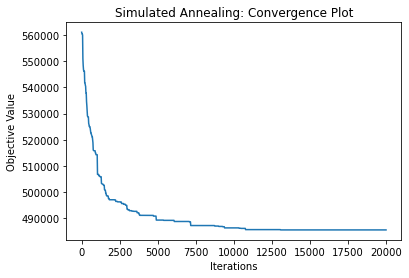

In [63]:
x = list(range(0, 20*1000, 20))
y = best_values_list
plt.plot(x, y)
plt.xlabel("Iterations")
plt.ylabel("Objective Value")
plt.title("Simulated Annealing: Convergence Plot")

### Distribution of Flights Per Gate (Initial Assignment)

In [91]:
assignment_df = pd.DataFrame.from_dict(list(assignment.items()))
assignment_df = assignment_df.rename(columns={0:"Flight Number", 1:"Gate"})

Text(0.5, 1.0, 'Distribution of Flights to Gates in Initial Assignment')

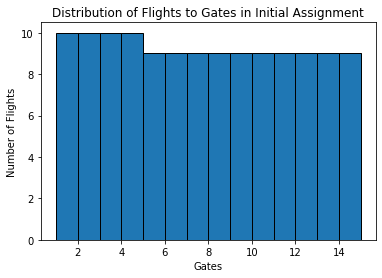

In [92]:
plt.hist(assignment_df["Gate"], bins=list(range(1,num_gates+2)), edgecolor="black")
plt.xlabel("Gates")
plt.ylabel("Number of Flights")
plt.title("Distribution of Flights to Gates in Initial Assignment")

### Distribution of Flights Per Gate (Best Assignment)

In [79]:
best_assignment_df = pd.DataFrame.from_dict(list(best_assignment.items()))
best_assignment_df = best_assignment_df.rename(columns={0:"Flight Number", 1:"Gate"})

In [80]:
best_assignment_df.head()

,Flight Number,Gate
0,1,12
1,15,7
2,29,4
3,43,13
4,57,3


In [81]:
best_assignment_df["Gate"].value_counts()

12    10
4     10
13    10
3     10
8     10
9     10
7      9
14     9
11     9
5      9
10     9
6      9
2      8
1      8
Name: Gate, dtype: int64

Text(0.5, 1.0, 'Distribution of Flights to Gates in Best Assignment')

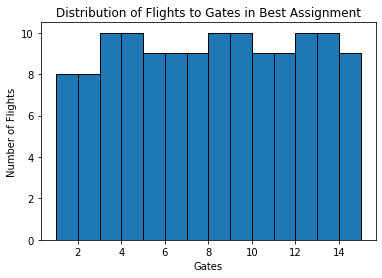

In [89]:
plt.hist(best_assignment_df["Gate"], bins=list(range(1,num_gates+2)), edgecolor="black")
plt.xlabel("Gates")
plt.ylabel("Number of Flights")
plt.title("Distribution of Flights to Gates in Best Assignment")

TODO: Create a plot with Time on the y-axis, gates on the x-axis, flights assigned to each gate as an "interval" with start time and end time